<a href="https://colab.research.google.com/github/arkothiwala/Analytics-Vidhya/blob/master/AV_GoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset



In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import torch
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN' #File ID for the required Trainingdata
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train-ship classification.zip')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('train-ship classification.zip', 'r')
zip_ref.extractall('data')
zip_ref.close()



---

Downloaded the data and unzipped

---



### Importing libraries and reading the data

# Roadmap:


1.   Load data


> 1.1 Determine missing data<br>
> 1.2 Add raw image data column<br>
> 1.3 Determine shapes of images<br>


2.   Process images



> 2.1 add padding<br>
> 2.2 add/remove dimentions







# 1. Load Data

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #To plot images
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
train_csv = pd.read_csv('./data/train.csv')
train_csv.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


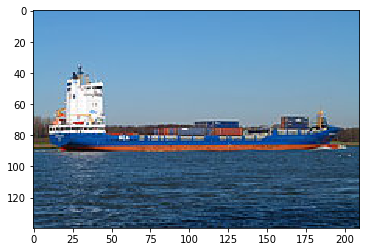

In [4]:
# Let's look at the image
img=mpimg.imread('./data/images/2823080.jpg')
imgplot = plt.imshow(img)

In [5]:
# Lets us see category column of the data
train_csv.category.describe()

count    6252.000000
mean        2.657550
std         1.528998
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: category, dtype: float64

In [6]:
# Null check
train_csv.isnull().sum()

image       0
category    0
dtype: int64

## 1.2 Add raw image data column

In [0]:
base_url = './data/images/'
# Create a column to represent raw image data
train_csv['raw'] = [mpimg.imread(base_url+image_url) for image_url in train_csv.image]

## 1.3 Image Processing



*   Some of the images can be of gray scale having just two channels
*   Such images needs to be converted to 3 channels (RGB values same as in single channel)



In [0]:
dim_dict = {}
for i in range(len(train_csv)):
  dimension = len(train_csv.raw.iloc[i].shape)
  if dimension in dim_dict:
    dim_dict[dimension] += 1
  else:
    dim_dict[dimension] = 1

In [9]:
dim_dict

{2: 104, 3: 6148}

As it can be noticed, some images are having two channels only. Which needs to be converted in to three channels

In [10]:
for i in range(len(train_csv.raw)):
  if(len(train_csv.raw.iloc[i].shape)==2):
    train_csv.raw.iloc[i] = np.stack((train_csv.raw.iloc[i],)*3, axis=-1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 3.3 Encoding category to One-Hot encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')
enc.fit(np.array(train_csv.category).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [12]:
train_csv['encoded_category'] = enc.transform(np.array(train_csv.category).reshape(-1,1)).toarray().tolist()
train_csv.encoded_category.head()

0    [1.0, 0.0, 0.0, 0.0, 0.0]
1    [1.0, 0.0, 0.0, 0.0, 0.0]
2    [0.0, 1.0, 0.0, 0.0, 0.0]
3    [0.0, 0.0, 1.0, 0.0, 0.0]
4    [0.0, 1.0, 0.0, 0.0, 0.0]
Name: encoded_category, dtype: object

Now we have encoded category list

# 2. Image preprocessing

Images in the dataset are of different size <br>
In order to feed it to the network, we need to make them to the same size <br>
Hence, let find out maximum dimensions of the image and pad smaller images with the same

#### Doubt: Should I first do augmentation then padding or viceversa ?

### Image resizing to max image size:

In [0]:
max_width = 0
max_height = 0
for image in train_csv.raw:
  height, width, depth = image.shape
  max_width = max(width, max_width)
  max_height = max(height, max_height)

In [14]:
max_width

210

In [15]:
max_height

158

In [0]:
min_width = 500
min_height = 500
for image in train_csv.raw:
  height, width, depth = image.shape
  min_width = min(width, min_width)
  min_height = min(height, min_height)

In [17]:
min_width

91

In [18]:
train_csv.head()

,image,category,raw,encoded_category
0,2823080.jpg,1,"[[[84, 153, 210], [84, 153, 210], [84, 153, 21...","[1.0, 0.0, 0.0, 0.0, 0.0]"
1,2870024.jpg,1,"[[[157, 157, 157], [153, 153, 153], [150, 150,...","[1.0, 0.0, 0.0, 0.0, 0.0]"
2,2662125.jpg,2,"[[[220, 219, 224], [220, 219, 224], [220, 219,...","[0.0, 1.0, 0.0, 0.0, 0.0]"
3,2900420.jpg,3,"[[[118, 140, 151], [136, 158, 169], [119, 143,...","[0.0, 0.0, 1.0, 0.0, 0.0]"
4,2804883.jpg,2,"[[[117, 152, 182], [118, 153, 183], [118, 153,...","[0.0, 1.0, 0.0, 0.0, 0.0]"


It shows that 104 images are 2D

In [0]:
import cv2
# Here we need to take care, as normally we will provide dsize = (height, width) but here it is swapped
train_csv['resized_raw'] = [cv2.resize(img, dsize=(max_width, max_height), interpolation=cv2.INTER_CUBIC) for img in train_csv.raw]

In [27]:
train_csv.resized_raw.to_numpy()[:2]

array([list([array([[ 84, 153, 210],
       [ 84, 153, 210],
       [ 84, 153, 210],
       [ 84, 153, 210],
       [ 84, 153, 210],
       [ 84, 153, 210],
       [ 84, 153, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 86, 152, 210],
       [ 87, 152, 210],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 86, 151, 209],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
       [ 88, 153, 211],
   

In [28]:
train_csv.head()

,image,category,raw,encoded_category,resized_raw
0,2823080.jpg,1,"[[[84, 153, 210], [84, 153, 210], [84, 153, 21...","[1.0, 0.0, 0.0, 0.0, 0.0]","[[[84, 153, 210], [84, 153, 210], [84, 153, 21..."
1,2870024.jpg,1,"[[[157, 157, 157], [153, 153, 153], [150, 150,...","[1.0, 0.0, 0.0, 0.0, 0.0]","[[[157, 157, 157], [151, 151, 151], [151, 151,..."
2,2662125.jpg,2,"[[[220, 219, 224], [220, 219, 224], [220, 219,...","[0.0, 1.0, 0.0, 0.0, 0.0]","[[[220, 219, 224], [220, 219, 224], [221, 220,..."
3,2900420.jpg,3,"[[[118, 140, 151], [136, 158, 169], [119, 143,...","[0.0, 0.0, 1.0, 0.0, 0.0]","[[[120, 142, 153], [134, 157, 167], [106, 133,..."
4,2804883.jpg,2,"[[[117, 152, 182], [118, 153, 183], [118, 153,...","[0.0, 1.0, 0.0, 0.0, 0.0]","[[[117, 152, 182], [118, 153, 183], [119, 153,..."


In [0]:
min_width = 500
min_height = 500
for image in train_csv.resized_raw:
  height, width, depth = image.shape
  min_width = min(width, min_width)
  min_height = min(height, min_height)

In [0]:
assert min_height == max_height
assert min_width == max_width

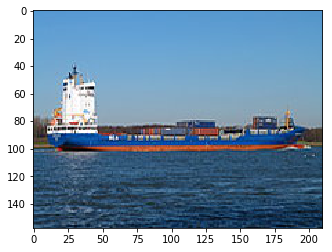

In [52]:
plt.imshow(train_csv.resized_raw.iloc[0])

Now I have all the images resized to same dimention and have encoded labels as well.<br>
Now is the time to build the model

# 4. Model Building

In [0]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=5, input_shape=(max_height, max_width,3)))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(32, kernel_size=5, input_shape=(max_height, max_width,3)))
model.add(keras.layers.Conv2D(8, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(5, activation='softmax'))

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 154, 206, 64)      4864      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 152, 204, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 76, 102, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 98, 32)        25632     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 70, 96, 8)         2312      
_________________________________________________________________
flatten_4 (Flatten)          (None, 53760)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 268805    
Total para

### 3. Splitting train-test data

Just splitting data in to training and test set

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(train_csv.resized_raw, train_csv.encoded_category, test_size=0.3)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [78]:
model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=5)

ValueError: ignored

In [82]:
np.array(train_X).reshape(len(train_X),train_X.iloc[0].shape[0],train_X.iloc[0].shape[1],train_X.iloc[0].shape[2]).shape

ValueError: ignored

In [85]:
np.array(train_X).shape

(4376,)

In [101]:
train_X.as_matrix().reshape((4376,train_X.iloc[0].shape[0],train_X.iloc[0].shape[1],train_X.iloc[0].shape[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [1]:
train_X.values[:2]

NameError: ignored